In [1]:
import keras
from keras import layers
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

2025-11-07 20:32:01.526936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762543921.542292  104384 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762543921.547041  104384 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762543921.559686  104384 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762543921.559722  104384 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762543921.559725  104384 computation_placer.cc:177] computation placer alr

# Tell the time network on smaller Dataset
## Starting with regression approach

### Setup Code

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
X = np.load('A1_data_75/images.npy')
X = X/255
y = np.load('A1_data_75/labels.npy')

In [4]:
y_min = np.array([i *60 +j for i,j in y])/(12*60)
y_hour_min = np.array([(i + j/60) for i, j in y])
y_cycle = np.array([[np.sin((2*np.pi*i)/720),np.cos((2*np.pi*i)/720)] for i in y_min])
y_norm = np.array([((i/12),(j/60)) for i,j in y ])

n_epochs = 50

## Minute Regression

In [5]:
y_reg = y_min
X_reg_train, X_reg_test, y_reg_train, y_reg_m_test = train_test_split(X,y_reg,test_size=0.1) 

model = keras.Sequential()
shape = X_reg_train.shape[1:]
input_shape = shape + (1,)

In [6]:
model.add(layers.Conv2D(filters=16,kernel_size=5,input_shape = input_shape))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(filters=32, kernel_size=4))
model.add(layers.Conv2D(filters=32, kernel_size=4))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(filters=64, kernel_size=3))
model.add(layers.Conv2D(filters=64, kernel_size=3))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation="linear"))

model.compile(optimizer="adam",loss="mse", metrics=["mae"])

/home/jaspe/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762543926.566914  104384 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6


In [7]:
hist_min = model.fit(
    X_reg_train,y_reg_train,
    validation_split=0.1,
    epochs=n_epochs,
    batch_size=32
)

y_pred_min = model.predict(X_reg_test)

Epoch 1/50


I0000 00:00:1762543929.761498  104452 service.cc:152] XLA service 0x7f5030005220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762543929.761533  104452 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-07 20:32:09.799513: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762543930.025944  104452 cuda_dnn.cc:529] Loaded cuDNN version 90101


 29/456 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2344 - mae: 0.3776

I0000 00:00:1762543933.175818  104452 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1153 - mae: 0.2782

2025-11-07 20:32:18.558613: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 20:32:18.705998: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109', 4 bytes spill stores, 4 bytes spill loads

2025-11-07 20:32:20.633683: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 20:32:20.649848: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109', 4 bytes spill stores, 4 bytes spill loads



456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0966 - mae: 0.2622 - val_loss: 0.0816 - val_mae: 0.2436
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0795 - mae: 0.2363 - val_loss: 0.0723 - val_mae: 0.2202
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0667 - mae: 0.2093 - val_loss: 0.0583 - val_mae: 0.1928
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0568 - mae: 0.1882 - val_loss: 0.0483 - val_mae: 0.1692
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0441 - mae: 0.1585 - val_loss: 0.0351 - val_mae: 0.1393
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0361 - mae: 0.1386 - val_loss: 0.0262 - val_mae: 0.1125
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0282 - mae: 0.1195 - val_loss: 0.0253 - val_mae: 0.1082
Epoch 8/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0248 - mae: 0.1104 - val_loss: 0.0223 - val_mae: 0.0959
Epoch 9/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.022

## hour.minute Regression

In [8]:
y_reg = y_hour_min
X_reg_train, X_reg_test, y_reg_train, y_reg_hm_test = train_test_split(X,y_reg,test_size=0.1) 

model = keras.Sequential()
shape = X_reg_train.shape[1:]
input_shape = shape + (1,)

In [9]:
model.add(layers.Conv2D(filters=16,kernel_size=5,input_shape = input_shape))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(filters=32, kernel_size=4))
model.add(layers.Conv2D(filters=32, kernel_size=4))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(filters=64, kernel_size=3))
model.add(layers.Conv2D(filters=64, kernel_size=3))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation="linear"))

model.compile(optimizer="adam",loss="mse", metrics=["mae"])

In [10]:
hist__hour_min = model.fit(
    X_reg_train,y_reg_train,
    validation_split=0.1,
    epochs=n_epochs,
    batch_size=32
)

y_pred_hour_min = model.predict(X_reg_test)

Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 13.7776 - mae: 3.1476 - val_loss: 14.8438 - val_mae: 3.2460
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.6860 - mae: 3.0391 - val_loss: 11.7440 - val_mae: 2.9471
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.4198 - mae: 2.9916 - val_loss: 10.9916 - val_mae: 2.8241
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.7202 - mae: 2.6852 - val_loss: 8.5268 - val_mae: 2.3116
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.3316 - mae: 2.2745 - val_loss: 7.6844 - val_mae: 2.1604
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.4528 - mae: 1.9533 - val_loss: 5.5144 - val_mae: 1.7383
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.1966 - mae: 1.7121 - val_loss: 4.9270 - val_mae: 1.6363
Epoch 8/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.0709 - mae: 1.4890 - val_loss: 3.8888 - val_mae: 1.4095
Epoch 9/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/s

### Hour and Minute (seperate) Regression

In [11]:
y_reg = y_norm
X_reg_train, X_reg_test, y_reg_train, y_reg_y_test = train_test_split(X,y_reg,test_size=0.1) 

model = keras.Sequential()
shape = X_reg_train.shape[1:]
input_shape = shape + (1,)

In [12]:
model.add(layers.Conv2D(filters=16,kernel_size=5,input_shape = input_shape))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(filters=32, kernel_size=4))
model.add(layers.Conv2D(filters=32, kernel_size=4))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(filters=64, kernel_size=3))
model.add(layers.Conv2D(filters=64, kernel_size=3))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(2, activation="linear"))

model.compile(optimizer="adam",loss="mse", metrics=["mae"])

In [13]:
hist_y = model.fit(
    X_reg_train,y_reg_train,
    validation_split=0.1,
    epochs=n_epochs,
    batch_size=32
)

y_pred_y = model.predict(X_reg_test)

Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0891 - mae: 0.2517 - val_loss: 0.0748 - val_mae: 0.2259
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0706 - mae: 0.2169 - val_loss: 0.0679 - val_mae: 0.2068
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0647 - mae: 0.2056 - val_loss: 0.0622 - val_mae: 0.2027
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0603 - mae: 0.1980 - val_loss: 0.0577 - val_mae: 0.1933
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0573 - mae: 0.1917 - val_loss: 0.0542 - val_mae: 0.1854
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0550 - mae: 0.1865 - val_loss: 0.0510 - val_mae: 0.1778
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0503 - mae: 0.1752 - val_loss: 0.0480 - val_mae: 0.1696
Epoch 8/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0465 - mae: 0.1657 - val_loss: 0.0421 - val_mae: 0.1557
Epoch 9/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - 

### Periodic Regression

In [39]:
y_reg = y_cycle
X_reg_train, X_reg_test, y_reg_train, y_reg_cycle_test = train_test_split(X,y_reg,test_size=0.1) 

model = keras.Sequential()
shape = X_reg_train.shape[1:]
input_shape = shape + (1,)

In [40]:
model.add(layers.Conv2D(filters=16,kernel_size=5,input_shape = input_shape))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(filters=32, kernel_size=4))
model.add(layers.Conv2D(filters=32, kernel_size=4))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(filters=64, kernel_size=3))
model.add(layers.Conv2D(filters=64, kernel_size=3))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(2, activation="linear"))

model.compile(optimizer="adam",loss="mse", metrics=["mae"])

In [41]:
hist_cycle = model.fit(
    X_reg_train,y_reg_train,
    validation_split=0.1,
    epochs=n_epochs,
    batch_size=32
)

y_pred_cycle = model.predict(X_reg_test)

Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0307 - mae: 0.0966 - val_loss: 7.0905e-05 - val_mae: 0.0064
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0059 - mae: 0.0542 - val_loss: 8.8498e-05 - val_mae: 0.0075
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0038 - mae: 0.0430 - val_loss: 1.7439e-04 - val_mae: 0.0109
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0029 - mae: 0.0371 - val_loss: 1.6512e-04 - val_mae: 0.0110
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0023 - mae: 0.0325 - val_loss: 3.9881e-05 - val_mae: 0.0055
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0018 - mae: 0.0287 - val_loss: 2.5878e-05 - val_mae: 0.0045
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0015 - mae: 0.0253 - val_loss: 6.7547e-05 - val_mae: 0.0068
Epoch 8/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 4.1614e-06 - val_mae: 0.0013
Epoch 9/50
456/456 ━━━

## Evaluation

In [17]:
def circular_mae(y_true, y_pred, period=730):
    diffs = np.abs(y_true - y_pred)
    diffs = np.minimum(diffs, period - diffs)
    return np.mean(diffs)

### Minute

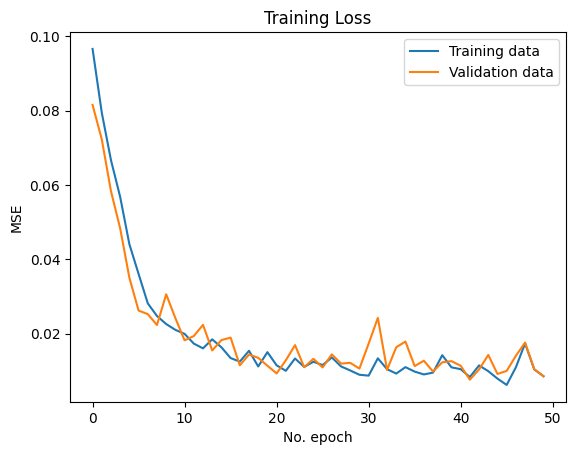

In [18]:
plt.plot(hist_min.history['loss'], label='Training data')
plt.plot(hist_min.history['val_loss'], label='Validation data')
plt.title('Training Loss')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [19]:
mae = circular_mae(y_reg_m_test*720, y_pred_min*720, 720)

print(f"Average prediciton error in minutes: {mae}")

Average prediciton error in minutes: 180.19438244631084


### hour.minute

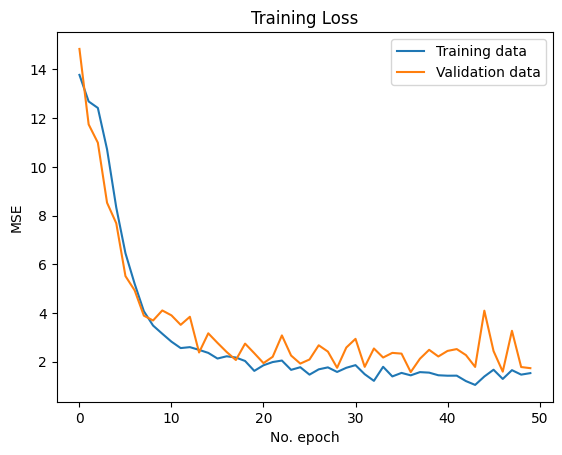

In [20]:
plt.plot(hist__hour_min.history['loss'], label='Training data')
plt.plot(hist__hour_min.history['val_loss'], label='Validation data')
plt.title('Training Loss')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [21]:
mae = circular_mae(y_reg_hm_test, y_pred_hour_min, 12.0)

print(f"Average prediciton error in minutes: {mae*60}")

Average prediciton error in minutes: 179.94854879415757


### Hour and minute

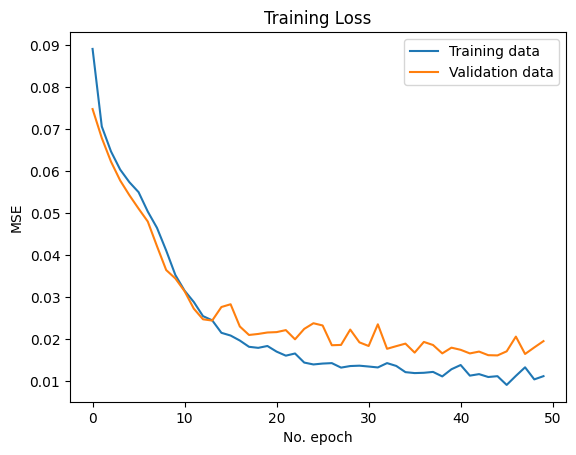

In [22]:
plt.plot(hist_y.history['loss'], label='Training data')
plt.plot(hist_y.history['val_loss'], label='Validation data')
plt.title('Training Loss')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [23]:
y_test = np.array([((i*12)*60+(j*60))for i,j in y_reg_y_test])
y_pred = np.array([((i*12)*60+(j*60))for i,j in y_pred_y])

mae = circular_mae(y_test, y_pred, 720)

print(f"Average prediciton error in minutes: {mae}")

Average prediciton error in minutes: 45.35604409429762


### Periodic

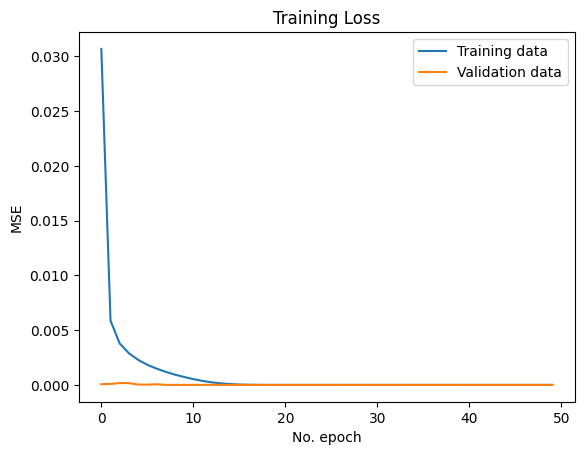

In [42]:
plt.plot(hist_cycle.history['loss'], label='Training data')
plt.plot(hist_cycle.history['val_loss'], label='Validation data')
plt.title('Training Loss')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [43]:
def decode_target_vals(y):
    angles_pred = np.arctan2(y[:, 0], y[:, 1])
    decoded = (angles_pred / (2 * np.pi)) * 720
    return (decoded+720)%720

In [44]:
y_reg_pred = model.predict(X_reg_test)
y_test = decode_target_vals(y_reg_cycle_test)
y_pred = decode_target_vals(y_reg_pred)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [45]:
error = np.abs(y_pred - y_test)
error = np.minimum(error, 720 - error)
mae = np.mean(error)
print("Mean Absolute Error (in minutes):", mae)

Mean Absolute Error (in minutes): 0.2511061921296286
